In [7]:
# Import libraries
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt

# Data reconcilliation

Consider a process where we have a water flowing through a series of pipes. At one point, the pipes splits, and then merge a little while later. The flowrates through the pipes can be varied using a pair of valves. See the image below for more details.

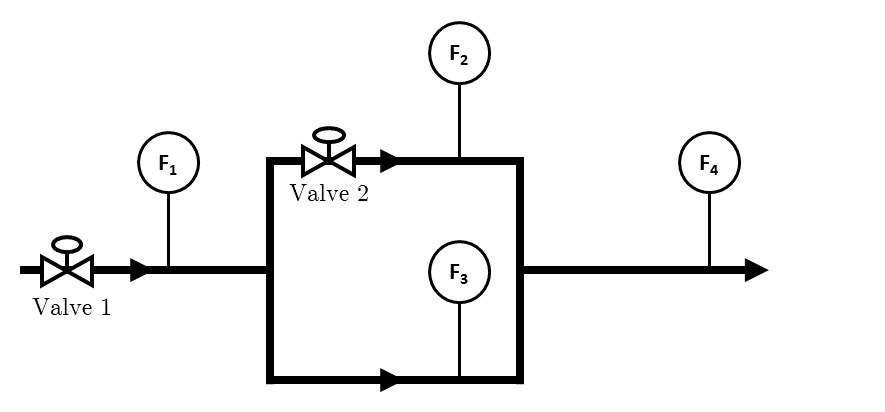

In [8]:
Image("Flow-system.jpg")

Each of the pipes are equipped with a flowrate sensor, giving the flowrate of water in the pipe in L/min. However, the measurements aren't perfectly accurated, they are corrupted by *random noise*. 

Let us group the set of measurements into a vector $ \mathbf{y} = [F_{n,1}, F_{n,2}, F_{n,3}, F_{n,4}] $, where the subscript $ n $ reminds us that the measurements are "noisy". We can similarly group the *true* flowrates into a vector $ \mathbf{x} = [F_{1}, F_{2}, F_{3}, F_{4}] $. Our goal is to estimate $ \mathbf{x} $ based on the noisy measurements $ \mathbf{y} $. However, we have additional information that we can use to improve our estimate.

We know that *mass is conserved* over each pipe intersection. In other words, the flowrate of water into the first intersection must equal the flowrate of water out of that intersection. The same applies for the second intersection. Mathematically:

$$ F_1 - F_2 - F_3 = 0 $$
$$ F_2 + F_3 - F_4 = 0 $$

We can also write this in matrix form:

\begin{equation}
\begin{bmatrix}
    1 & -1 & -1 & 0 \\
    0 &  1 &  1 & -1
\end{bmatrix}
\begin{bmatrix}
    F_1 \\
    F_2 \\
    F_3 \\
    F_4
\end{bmatrix}
=
\begin{bmatrix}
    0 \\
    0 \\
    0 \\
    0
\end{bmatrix}
\end{equation}

$$ \therefore A \mathbf{x} = 0 $$


So, given a set of measurements $ \mathbf{y} $ and a set of constraints on the true values $ A \mathbf{x} = 0 $ (given by our mass balance), we would like to determine the values $ \mathbf{x} $ that are as close as possible to $ \mathbf{y} $ while satisfying the constraints. Essentially, we want to solve the following:

$$ \displaystyle{\min_{\mathbf{x}} | \mathbf{y} - \mathbf{x} |^2} $$
$$ \mathrm{subject \, to} \, A\mathbf{x} = 0 $$

This problem can be solved using the method of Lagrange multipliers, in other words, by minimizing the following:

$$ \displaystyle{\min_{\mathbf{x, λ}} J(\mathbf{x}, λ) } $$
$$ J(\mathbf{x}, λ) = | \mathbf{y} - \mathbf{x} |^2 - λ A \mathbf{x} $$

By setting $ \frac{∂J}{∂x} = 0 $ and $ \frac{∂J}{∂λ} = 0 $, we can obtain the solution:

$$ \mathbf{x} = \mathbf{y} - A^T(AA^T)^{-1}A \mathbf{y} $$

An alternative approach is to find the nullspace $ N(A) $ of $ A $, such that $ A \mathbf{v} = 0 \,\, ∀ \,\, \mathbf{v} ∈ N(A) $.

We can then use $ \mathbf{x} = \sum{\alpha_i \mathbf{v}_i} $ and find the values of $ \alpha_i $ which minimizes the following:
$$ \displaystyle{\min_{\mathbf{\alpha}}} | \mathbf{y} - \sum{\alpha_i \mathbf{v}_i} |^2 $$ 

This essentially amounts to projecting $ \mathbf{y} $ onto $ \mathbf{v}_i $, and the solution is:

$$ \alpha_i = \mathbf{y} \cdot  \mathbf{v}_i $$

$$ ∴ \mathbf{x} = \sum{α_i\mathbf{v}_i}  = \sum{ (\mathbf{y} \cdot  \mathbf{v}_i) \mathbf{v}_i} = V V^T \mathbf{y} $$

An example is given below, where a set of "true" flowrates are generated (with step changes in the flowrates corresponding to an operator adjusting a valve). We then add random noise to the true flowrates to simulate the measurements $ \mathbf{y} $. Finally, we use our data reconcilliation strategy to obtain an improved estimate $ \mathbf{x} $.

The mean absolute percentage error for the measurements are 5.317 %
The mean absolute percentage error for the estimates are 3.812 %


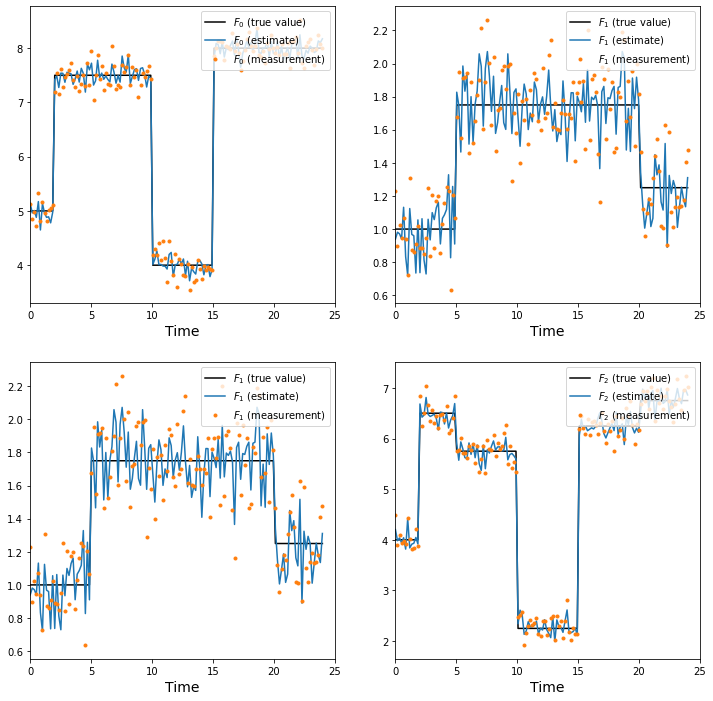

In [9]:
# Define the constraints matrix
A = np.array([[-1, 1, 1, 0], [0, -1, -1, 1]])
m, p = A.shape

# Generate a true data set with step changes in the flowrates, as well as a set of noisy measurements
N = 24*6
t = np.linspace(0, 24, N)
F_true = np.zeros((4, N))
F_true[0] = 5 + 2.5*(t > 2) - 3.5*(t > 10) + 4*(t>15)
F_true[1] = 1 + 0.75*(t > 5) - 0.5*(t > 20)
F_true[2] = F_true[0] - F_true[1]
F_true[3] = F_true[0]
F_noisy = F_true + np.random.normal(0, 0.2, (4, N))

F_estimate = np.zeros((4,N))

# Estimate using method of Lagrange multipliers
# Q = A.T @ np.linalg.inv(A @ A.T) @ A
# for j in range(N):
#     F_estimate[:,j] = F_noisy[:, j] - Q @ F_noisy[:,j]

# Estimate using method of projection into the nullspace
# Identify an orthonormal set of vectors in matrix V, where the first "m" columns are colinear with the rows of "A"
V = np.eye(4)
V[:,range(m)] = A.T

for j in range(4):
    for i in range(j):
        V[:,j] -= np.dot(V[:,j], V[:,i]) * V[:,i]
    V[:,j] = V[:,j] / np.linalg.norm(V[:,j])

# Only retain the last p-m basis vectors, which represents the nullspace
V = np.delete(V, range(m), axis = 1)

# Project into nullspace
for j in range(N):
    F_estimate[:,j] = V @ V.T @ F_noisy[:, j]



# Plot the results
fig, ax = plt.subplots(2,2)
fig.set_size_inches(12,12)
for i in range(2):
    for j in range(2):
        k = i+j
        ax[i,j].plot(t, F_true[k], 'k', label = rf'$ F_{k} $ (true value)')
        ax[i,j].plot(t, F_estimate[k], label = rf'$ F_{k} $ (estimate)')
        ax[i,j].plot(t, F_noisy[k], '.', label = rf'$ F_{k} $ (measurement)')
        ax[i,j].legend(loc = 'upper right')
        ax[i,j].set_xlabel('Time', fontsize = 14)
        ax[i,j].set_xlim(left = 0, right = 25)
        

Error_measurement = np.mean(np.abs((F_noisy - F_true))/F_true, axis = (0,1))*100
Error_estimate = np.mean(np.abs(F_estimate - F_true)/F_true, axis = (0,1))*100
print(f"The mean absolute percentage error for the measurements are {Error_measurement:.3f} %")
print(f"The mean absolute percentage error for the estimates are {Error_estimate:.3f} %")
